In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from ignite.metrics import Accuracy, Precision, Recall

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import albumentations as A

In [2]:
MNIST_1 = datasets.MNIST('', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

MNIST_2 = datasets.MNIST('', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

In [3]:
class Noisy(torch.utils.data.Dataset):
    
    def __init__(self, dataset, phase=None):

        if phase == 'train':
            start = 0
            end = int(len(dataset)*.75)
        elif phase == 'val':
            start = int(len(dataset)*.75)
            end = len(dataset)
        else:
            start = 0
            end = len(dataset)

        self.dataset = dataset.data[start:end] / 255

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        data = (self.dataset[idx] + torch.rand(28, 28) * 0.3 ).unsqueeze(0)
        target = self.dataset[idx].unsqueeze(0)
            
        return data, target

In [4]:
NOISY_train_dataset = Noisy(MNIST_1, 'train')
NOISY_val_dataset = Noisy(MNIST_1, 'val')
NOISY_test_dataset = Noisy(MNIST_2, 'test')

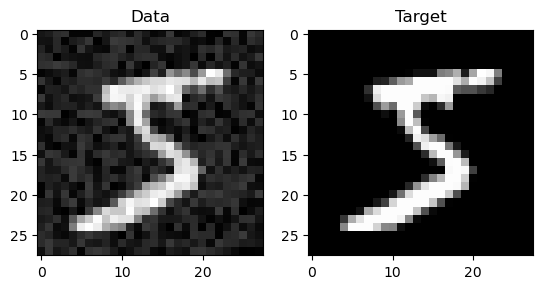

In [5]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(NOISY_train_dataset[0][0].squeeze(), cmap='gray')
axs[1].imshow(NOISY_train_dataset[0][1].squeeze(), cmap='gray')

axs[0].title.set_text('Data')
axs[1].title.set_text('Target')

plt.show()

In [6]:
denoiser = nn.Sequential(
    # encode
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),

    # decode
    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 1, kernel_size=3, padding=1),
    nn.ReLU(),
)

In [7]:
%%capture

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

denoiser.to(device)

In [8]:
def train_denoiser(model, batch_size, learning_rate, num_epochs, train_dataset, val_dataset):

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    loss_fn = torch.nn.MSELoss()
    
    total_progress = tqdm(total=num_epochs, desc='Total progress')
    epoch_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_progress = tqdm(total=len(train_loader), desc=f'Training epoch #{epoch}...', leave=False)
        for data, target in train_loader:
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            epoch_progress.update()
        epoch_progress.close()

        model.eval()
        val_progress = tqdm(total=len(val_loader), desc=f'Validating epoch #{epoch}...', leave=False)
        val_losses = []
        for data, target in val_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            loss = loss_fn(output, target)
            val_losses.append(loss.item())
            val_progress.update()
        val_progress.close()

        mean_val_loss = np.mean(val_losses)
        epoch_losses.append(mean_val_loss)
        if mean_val_loss == min(epoch_losses):
            torch.save(model, 'denoiser_least_loss.pt')

        scheduler.step(mean_val_loss)

        print(f"Val loss #{epoch}: {np.mean(val_losses)}")

        total_progress.update()

    total_progress.close()

In [9]:
train_denoiser(model=denoiser,
                 batch_size=64,
                 learning_rate=0.1,
                 num_epochs=10,
                 train_dataset=NOISY_train_dataset,
                 val_dataset=NOISY_val_dataset
                )

Total progress:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch #0...:   0%|          | 0/704 [00:00<?, ?it/s]

Validating epoch #0...:   0%|          | 0/235 [00:00<?, ?it/s]

Val loss #0: 0.008093517438132079


Training epoch #1...:   0%|          | 0/704 [00:00<?, ?it/s]

Validating epoch #1...:   0%|          | 0/235 [00:00<?, ?it/s]

Val loss #1: 0.00531582120766348


Training epoch #2...:   0%|          | 0/704 [00:00<?, ?it/s]

Validating epoch #2...:   0%|          | 0/235 [00:00<?, ?it/s]

Val loss #2: 0.003493707137618293


Training epoch #3...:   0%|          | 0/704 [00:00<?, ?it/s]

Validating epoch #3...:   0%|          | 0/235 [00:00<?, ?it/s]

Val loss #3: 0.003074487474093095


Training epoch #4...:   0%|          | 0/704 [00:00<?, ?it/s]

Validating epoch #4...:   0%|          | 0/235 [00:00<?, ?it/s]

Val loss #4: 0.002813753281581275


Training epoch #5...:   0%|          | 0/704 [00:00<?, ?it/s]

Validating epoch #5...:   0%|          | 0/235 [00:00<?, ?it/s]

Val loss #5: 0.0026523101757815544


Training epoch #6...:   0%|          | 0/704 [00:00<?, ?it/s]

Validating epoch #6...:   0%|          | 0/235 [00:00<?, ?it/s]

Val loss #6: 0.0028724522389313007


Training epoch #7...:   0%|          | 0/704 [00:00<?, ?it/s]

Validating epoch #7...:   0%|          | 0/235 [00:00<?, ?it/s]

Val loss #7: 0.0023791850594050705


Training epoch #8...:   0%|          | 0/704 [00:00<?, ?it/s]

Validating epoch #8...:   0%|          | 0/235 [00:00<?, ?it/s]

Val loss #8: 0.0023667612271581558


Training epoch #9...:   0%|          | 0/704 [00:00<?, ?it/s]

Validating epoch #9...:   0%|          | 0/235 [00:00<?, ?it/s]

Val loss #9: 0.002476895026902252


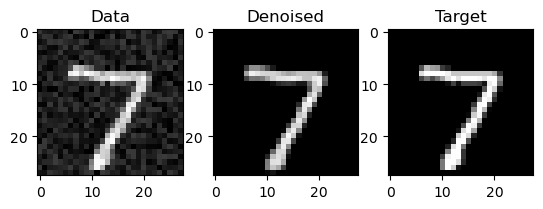

In [10]:
denoiser.eval()
output = denoiser(NOISY_test_dataset[0][0].unsqueeze(0).to(device))

fig, axs = plt.subplots(1, 3)

axs[0].imshow(NOISY_test_dataset[0][0].squeeze(), cmap='gray')
axs[1].imshow(output.cpu().detach().numpy().squeeze(), cmap='gray')
axs[2].imshow(NOISY_test_dataset[0][1].squeeze(), cmap='gray')

axs[0].title.set_text('Data')
axs[1].title.set_text('Denoised')
axs[2].title.set_text('Target')

plt.show()

**Training a classifier (for the denoiser  evaluation)**

In [11]:
class MNIST(torch.utils.data.Dataset):
    
    def __init__(self, dataset, phase=None, augment=False, normalize=False):
        
        if augment:
            self.transform = A.Compose([
                A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=1.0)
            ])      
        
        self.augment = augment
        self.normalize = normalize

        if phase == 'train':
            start = 0
            end = int(len(dataset)*.75)
        elif phase == 'val':
            start = int(len(dataset)*.75)
            end = len(dataset)
        else:
            start = 0
            end = len(dataset)

        self.data = dataset.data[start:end] / 255
        self.targets = dataset.targets[start:end]

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        data = self.data[idx]
        target = self.targets[idx]
        
        if self.augment:
            data = torch.tensor(self.transform(image=data.numpy())['image'])
        
        if self.normalize:
            data = (data - data.mean()) / data.std()
            
        return data.unsqueeze(0), target

In [12]:
MNIST_train_dataset = MNIST(MNIST_1, 'train', True, True)
MNIST_val_dataset = MNIST(MNIST_1, 'val', True, True)
MNIST_test_dataset = MNIST(MNIST_2, 'test', False, False)

In [13]:
classifier = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(7*7*64, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 10),
)

In [14]:
%%capture

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

classifier.to(device)

In [15]:
def train_classifier(model, batch_size, learning_rate, num_epochs, train_dataset, val_dataset):

    MNIST_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    MNIST_val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    loss_fn = torch.nn.CrossEntropyLoss()

    total_progress = tqdm(total=num_epochs, desc='Total progress')
    epoch_losses = []
    epoch_accuracies = []
    accuracy = Accuracy()

    for epoch in range(num_epochs):
        model.train()
        epoch_progress = tqdm(total=len(MNIST_train_loader), desc=f'Training epoch #{epoch}...', leave=False)
        for data, target in MNIST_train_loader:
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            epoch_progress.update()
        epoch_progress.close()

        model.eval()
        val_progress = tqdm(total=len(MNIST_val_loader), desc=f'Validating epoch #{epoch}...', leave=False)
        val_losses = []
        accuracy.reset()
        for data, target in MNIST_val_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            loss = loss_fn(output, target)
            val_losses.append(loss.item())
            val_progress.update()
            accuracy.update((output, target))
        val_progress.close()

        mean_val_loss = np.mean(val_losses)
        epoch_losses.append(mean_val_loss)
        current_accuracy = accuracy.compute()
        epoch_accuracies.append(current_accuracy)
        if current_accuracy == max(epoch_accuracies):
            torch.save(model, 'classifier_best_accuracy.pt')

        scheduler.step(mean_val_loss)

        print(f"Val loss #{epoch}: {np.mean(val_losses)}")
        print(f"Val accuracy #{epoch}: {current_accuracy}")

        total_progress.update()

    total_progress.close()

In [16]:
train_classifier(model=classifier,
                 batch_size=256,
                 learning_rate=0.1,
                 num_epochs=10,
                 train_dataset=MNIST_train_dataset,
                 val_dataset=MNIST_val_dataset
                )

Total progress:   0%|          | 0/15 [00:00<?, ?it/s]

Training epoch #0...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #0...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #0: 0.604384762250771
Val accuracy #0: 0.81


Training epoch #1...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #1...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #1: 0.15926841595920466
Val accuracy #1: 0.9482


Training epoch #2...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #2...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #2: 0.10909312515188072
Val accuracy #2: 0.9661333333333333


Training epoch #3...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #3...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #3: 0.07956705633866584
Val accuracy #3: 0.9756666666666667


Training epoch #4...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #4...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #4: 0.07082060370909965
Val accuracy #4: 0.9778666666666667


Training epoch #5...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #5...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #5: 0.06527157399361416
Val accuracy #5: 0.9793333333333333


Training epoch #6...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #6...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #6: 0.08145633336724871
Val accuracy #6: 0.9729333333333333


Training epoch #7...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #7...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #7: 0.05303549351391651
Val accuracy #7: 0.9832


Training epoch #8...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #8...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #8: 0.0525792830828893
Val accuracy #8: 0.984


Training epoch #9...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #9...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #9: 0.05131757339873051
Val accuracy #9: 0.9845333333333334


Training epoch #10...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #10...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #10: 0.0464626527628151
Val accuracy #10: 0.986


Training epoch #11...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #11...:   0%|          | 0/59 [00:00<?, ?it/s]

KeyboardInterrupt: 

**Evaluation**

In [17]:
%%capture

best_denoiser = torch.load('least_loss.pt')
best_classifier = torch.load('best_accuracy.pt')

best_denoiser.to(device).eval()
best_classifier.to(device).eval()

In [18]:
MNIST_test_loader = torch.utils.data.DataLoader(MNIST_test_dataset, batch_size=256, shuffle=True)
accuracy = Accuracy()
precision = Precision()
recall = Recall()

In [29]:
def evaluate(classifier, data_loader, accuracy, precision, recall, add_noise=False, denoiser=None):
    
    accuracy.reset()
    precision.reset()
    recall.reset()
    
    classifier.eval()
    if denoiser:
        denoiser.eval()
        
    for data, target in data_loader:
        
            data = data.to(device)
            
            if add_noise:
                noise = torch.rand(len(data), 1, 28, 28) * 0.3
                data += noise.to(device)

            if denoiser:
                data = denoiser(data)
                
            # standardization
            data = (data - data.mean()) / data.std()
    
            target = target.to(device)
            output = best_classifier(data)
            accuracy.update((output, target))
            precision.update((output, target))
            recall.update((output, target))

    print(f'Test accuracy: {accuracy.compute()}')
    print(f'Test precision: {precision.compute().mean()}')
    print(f'Test precision: {recall.compute().mean()}')


In [34]:
evaluate(best_classifier, MNIST_test_loader, accuracy, precision, recall, add_noise=True, denoiser=best_denoiser)

Test accuracy: 0.9919
Test precision: 0.9919698609467955
Test precision: 0.9918252841513695
